# Análisis Explotarorio de los datos

In [1]:
import numpy as np
import pandas as pd

import librosa
import librosa.display

# Visualización
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
from matplotlib.patches import Rectangle
import seaborn as sns

import os
from glob import glob

In [2]:
# Definiendo algunas rutas
data_dir = '../datos'
train_audios_dir = os.path.join(data_dir,"train")
test_audios_dir = os.path.join(data_dir,"test")

train_files_paths = glob(os.path.join(train_audios_dir, "*.flac"))
test_files_paths = glob(os.path.join(test_audios_dir, "*.flac"))

# Explorando csvs

Cada archivo tiene:
* recording_id: identificador del archivo
* species_id: identificador de la especie (son 9)
* songtype_id: identificador del tipo de sonido que el animal emite? (creo que es como tipo de sonido: ladrido, maullar)
* t_min: inicio de la señal (se escucha alguna especie) en segundos
* t_max: fin de la señal en segundos
* f_min: frecuencia más baja durante la señal
* f_max: frecuencia más alta durante la señal

Son dos archivos:
* uno de verdaderos positivos
* y otro de falsos positivos

Se van a unir ambos archivos, y se creará una nueva columna que indique si son verdaderos positivos o no

In [3]:
df_tp = pd.read_csv(os.path.join(data_dir, "train_tp.csv"))
df_tp["is_tp"] = True

df_fp = pd.read_csv(os.path.join(data_dir, "train_fp.csv"))
df_fp["is_tp"] = False

df_p = pd.concat([df_tp, df_fp], axis=0)
df_p.reset_index(drop=True, inplace=True)
df_p

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,is_tp
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,True
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,True
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,True
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,True
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,True
...,...,...,...,...,...,...,...,...
8992,ffd88cd84,14,1,3.2000,2531.250,3.7867,5531.25,False
8993,ffebe7313,1,1,35.2000,3843.750,36.0960,5625.00,False
8994,fff163132,17,4,22.5547,1312.500,25.0880,7406.25,False
8995,fff163132,14,1,37.0827,2531.250,37.6693,5531.25,False


Al querer pivotear la tabla, donde los índices sea el `recording_id` y las columnas sean `species_id` usando el método de `df_p.pivot`, dará un error de que el par `(recording_id, species_id)` contiene duplicados. Esto significa que para un audio, hay dos registros con el mismo species_id

In [19]:
df_p[df_p.duplicated(["recording_id", "species_id"], keep=False)]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,is_tp
19,03b96f209,16,4,30.9333,3093.75,32.7680,4593.75,True
20,03b96f209,16,4,49.6320,3093.75,51.4667,4593.75,True
28,053aeb7bd,23,4,9.8569,6459.96,17.7807,11627.90,True
29,053aeb7bd,23,4,0.9520,6459.96,8.8758,11627.90,True
56,0c48ed342,17,1,50.0320,1312.50,56.4853,3937.50,True
...,...,...,...,...,...,...,...,...
8950,ff21001e6,15,1,1.7333,93.75,5.0773,1125.00,False
8982,ff858780b,15,1,0.0160,93.75,3.3600,1125.00,False
8983,ff858780b,15,1,10.3040,93.75,13.6480,1125.00,False
8989,ffd88cd84,14,1,2.1547,2531.25,2.7413,5531.25,False


No solamente eso, para un mismo audio y especie, la bandera de verdadero positivo es incongruente

In [21]:
df_p.groupby(["recording_id", "species_id"])["is_tp"].mean().unique()

array([0.        , 1.        , 0.5       , 0.66666667])

In [31]:
df_congruencia = df_p.groupby(["recording_id", "species_id"])["is_tp"].mean().isin([0.,1.]).rename("congruente").reset_index()
df_congruencia[~df_congruencia["congruente"]]

,recording_id,species_id,congruente
442,0c48ed342,17,False
848,178b835e3,16,False
1500,2c97a8020,17,False
4846,8f3d579c8,17,False
5495,a2441a74b,17,False
6346,bda762977,17,False


In [30]:
df_p[df_p["recording_id"] == "0c48ed342"]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,is_tp
56,0c48ed342,17,1,50.0320,1312.50,56.4853,3937.50,True
1617,0c48ed342,2,1,53.6640,468.75,55.4400,3000.00,False
1618,0c48ed342,19,1,47.4933,281.25,49.0453,2812.50,False
1619,0c48ed342,17,4,43.5413,1312.50,46.0747,7406.25,False


Crearemos una función que resuelva este tipo de conflictos para cada archivo de audio y especie

In [88]:
def agregar_audio_y_especie(df):
    if df["is_tp"].nunique() != 1:
        df = df[df["is_tp"]].copy() # consideremos el caso verdadero
        
    variables = ["t_min", "t_max", "f_min", "f_max", "is_tp"]
    agg = df.groupby(["recording_id", "species_id"])[variables].mean().values
    return pd.Series(data=agg.flatten(), index=variables)

In [90]:
df = df_p.groupby(["recording_id", "species_id"]).apply(agregar_audio_y_especie).reset_index()
df["duration"] = df["t_max"] - df["t_min"]
df["bandwidth"] = df["f_max"] - df["f_min"]
df

,recording_id,species_id,t_min,t_max,f_min,f_max,is_tp,duration,bandwidth
0,00204008d,4,15.0027,16.8587,2343.7500,4218.7500,False,1.8560,1875.0000
1,00204008d,8,24.4960,28.6187,3750.0000,5531.2500,False,4.1227,1781.2500
2,00204008d,21,13.8400,14.9333,3281.2500,4125.0000,False,1.0933,843.7500
3,003b04435,22,43.2533,44.8587,10687.5000,13687.5000,False,1.6054,3000.0000
4,003b04435,23,9.1254,15.2091,7235.1562,11283.3984,False,6.0837,4048.2422
...,...,...,...,...,...,...,...,...,...
8615,ffd88cd84,17,49.1253,51.6587,1312.5000,7406.2500,False,2.5334,6093.7500
8616,ffebe7313,1,35.2000,36.0960,3843.7500,5625.0000,False,0.8960,1781.2500
8617,fff163132,14,37.0827,37.6693,2531.2500,5531.2500,False,0.5866,3000.0000
8618,fff163132,17,22.5547,25.0880,1312.5000,7406.2500,False,2.5333,6093.7500


In [92]:
df.to_csv(os.path.join(data_dir,"train_long.csv"), index=False)

## Distribución de etiquetas

False    7459
True     1161
Name: is_tp, dtype: int64


<AxesSubplot:xlabel='is_tp', ylabel='count'>

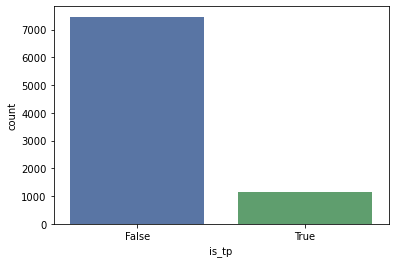

In [93]:
print(df["is_tp"].value_counts(normalize=False))
sns.countplot(data=df, x="is_tp",)

Se tiene un desbalanceo considerable de las etiquetas

## Distribución de las especies

<AxesSubplot:xlabel='species_id', ylabel='count'>

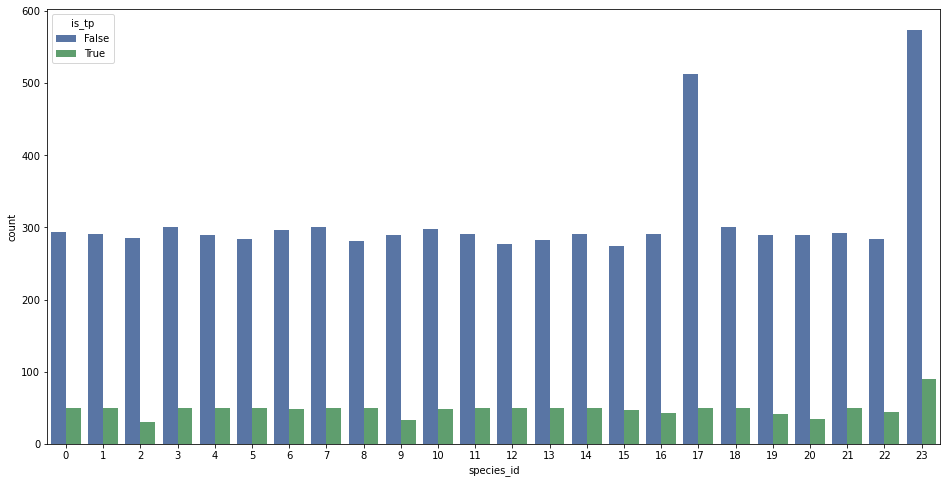

In [94]:
plt.figure(figsize=(16,8))
sns.countplot(data=df, x="species_id", hue="is_tp")

Text(0.5, 0.98, 'Distribución de especies')

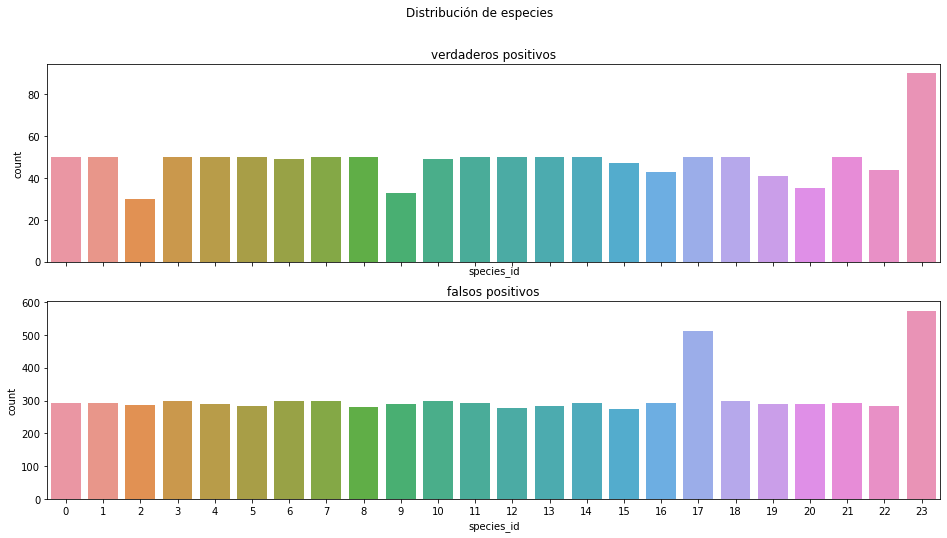

In [95]:
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
sns.countplot(data=df.query("is_tp"), x="species_id", ax=ax[0])
ax[0].set_title("verdaderos positivos")
sns.countplot(data=df.query("not is_tp"), x="species_id", ax=ax[1])
ax[1].set_title("falsos positivos")
fig.suptitle("Distribución de especies")

## Distribución de las duraciones

<AxesSubplot:xlabel='is_tp', ylabel='duration'>

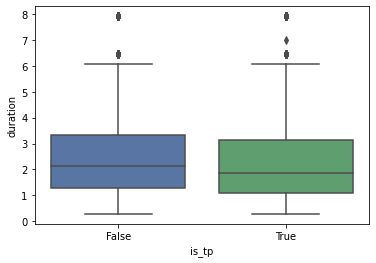

In [96]:
sns.boxplot(data=df, x="is_tp", y="duration")

Las duraciones en general son muy parecidas entre verdaderos positivos y falsos positivos

<AxesSubplot:xlabel='species_id', ylabel='duration'>

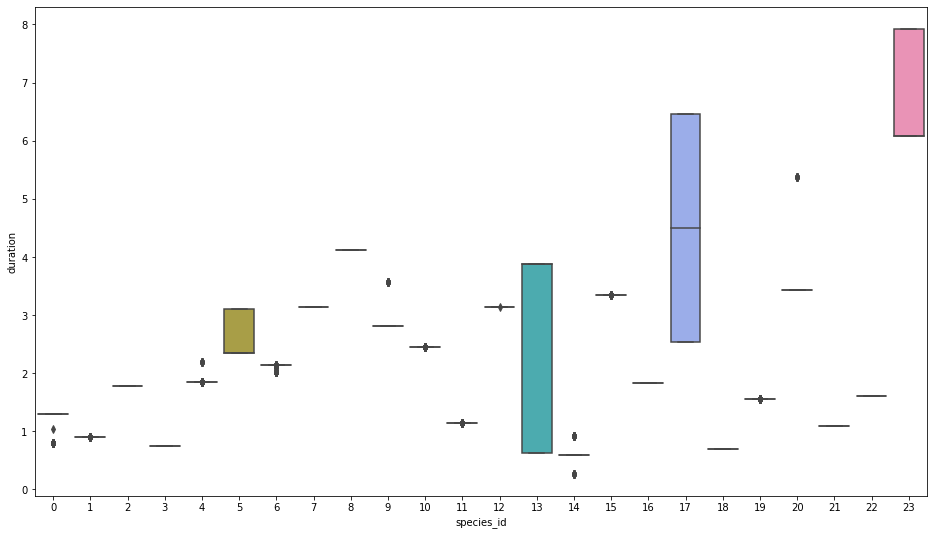

In [97]:
plt.figure(figsize=(16,9))
sns.boxplot(data=df, x="species_id", y="duration")

Casi todas las especies tiene en general una duración en concreto.

Las especies 5, 13, 17 y 23 si tienen duraciones variables, y otras en general tiene duraciones atípicas, lo cuales podrían ser los más complicados de estimar

## Distribuciones de anchos de banda

<AxesSubplot:xlabel='species_id', ylabel='bandwidth'>

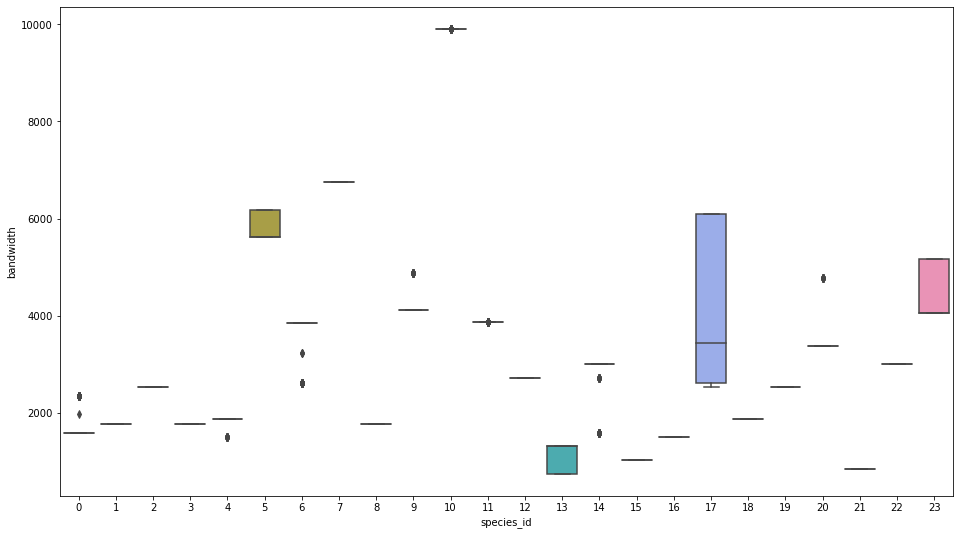

In [98]:
plt.figure(figsize=(16,9))
sns.boxplot(data=df, x="species_id", y="bandwidth")

## ¿Hay especies que aparecen más de un vez?

In [99]:
df.groupby("recording_id")["species_id"].count().max()

8

Al parecer sí

Text(0.5, 0, 'Número de especies en un audio')

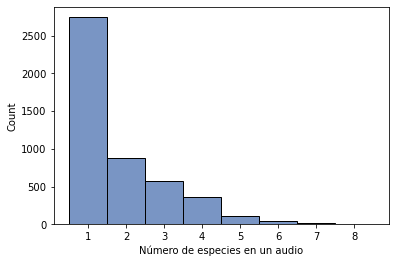

In [100]:
sns.histplot(data=df.groupby("recording_id")["species_id"].count(), discrete=True)
plt.xlabel("Número de especies en un audio")

# Traslapes

¿Se traslapan las señales?

In [101]:
record2omas_mask = (df.groupby("recording_id")["species_id"].count() > 1)
record2omas = record2omas_mask[record2omas_mask].index
record2omas

Index(['00204008d', '003b04435', '0079ff47b', '007f87ba2', '00e3525a2',
       '015113cad', '0171866c7', '0178fe09a', '01a976045', '01ceb73a1',
       ...
       'ff56888a1', 'ff5c2d55f', 'ff672e3bb', 'ff6aa0e63', 'ff6acf404',
       'ff7f876bd', 'ff858780b', 'ffc6031f8', 'ffd88cd84', 'fff163132'],
      dtype='object', name='recording_id', length=1982)

In [102]:
df_2omas = df[df["recording_id"].isin(record2omas)]

In [103]:
def hay_traslape(inicios, finales):
    assert len(inicios) == len(finales)
    n = len(inicios)
    for i in range(n):
        assert inicios[i] < finales[i]
        for j in range(n):
            if inicios[i] < inicios[j] < finales[i]:
                return True
        
    return False
            

In [104]:
hay_traslape([1,15], [10,18])

False

In [114]:
señales_con_traslape = []
for group_id, df_grouped in df_2omas.groupby("recording_id"):
    tiempos_iniciales = df_grouped["t_min"].values
    tiempos_finales = df_grouped["t_max"].values
    if hay_traslape(tiempos_iniciales, tiempos_finales):
        señales_con_traslape.append(group_id)
    
print(f"De los {record2omas.size} audios donde se presentan varias especies, "
      f"en {len(señales_con_traslape)} se traslapan")

De los 1982 audios donde se presentan varias especies, en 608 se traslapan


In [115]:
señales_con_traslape[1]

'02b9a8ab9'

# Pivotando la tabla

In [110]:
df_pivote = df.pivot(index="recording_id", columns="species_id", values="is_tp")
df_pivote.columns = [f"species_{species_id}" for species_id in df_pivote.columns]
df_pivote.fillna(-1, inplace=True)
for col in df_pivote:
    df_pivote[col] = df_pivote[col].astype(int)
df_pivote

,species_0,species_1,species_2,species_3,species_4,species_5,species_6,species_7,species_8,species_9,...,species_14,species_15,species_16,species_17,species_18,species_19,species_20,species_21,species_22,species_23
recording_id,,,,,,,,,,,,,,,,,,,,,
00204008d,-1,-1,-1,-1,0,-1,-1,-1,0,-1,...,-1,-1,-1,-1,-1,-1,-1,0,-1,-1
003b04435,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,0,0
003bec244,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
005f1f9a5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
006ab765f,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc6031f8,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,0,-1,-1,-1,-1,-1,0
ffd88cd84,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,-1,-1,0,-1,-1,-1,-1,-1,-1
ffebe7313,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [111]:
df_pivote.to_csv(os.path.join(data_dir, "train_wide.csv"))

* -1: No aparece
* 0: Falso positivo
* 1: Verdadero positivo

Pregunta: para un mismo archivo, ¿hay verdaderos y falsos postivios

In [112]:
casos_marcianos = 0
for recording_id in df_pivote.index:
    if df_pivote.loc[recording_id].nunique() == 3:
        casos_marcianos += 1
        
    if df_pivote.loc[recording_id].nunique() == 1:
        print(recording_id, df_pivote.loc[recording_id].unique())
        
print(f"Hay {casos_marcianos} casos donde hay verdaderos y falsos positivos")

Hay 363 casos donde hay verdaderos y falsos positivos


# Explorando audios

In [14]:
print(f"Se cuentan con {len(train_files_paths)} audios de entrenamiento")
print(f"Se cuentan con {len(test_files_paths)} audios para predicción")

Se cuentan con 4727 audios de entrenamiento
Se cuentan con 1992 audios para predicción


**Prueba de cordura**: ¿Tenemos todos los archivos?

In [15]:
recording_ids = df_p["recording_id"].unique()

print(recording_ids.size == len(train_files_paths))

counter = 0
for recording_id in recording_ids:
    for file_path in train_files_paths:
        if recording_id in file_path:
            counter += 1
            break
    else: # se ejecuta si nunca se invoco el break
        print(f"{recording_id} no está!")
        
counter == recording_ids.size

True


True

## Distribución de duraciones

```
%%time
duraciones = np.empty(len(train_files_paths))
for i,filepath in enumerate(train_files_paths):
    if (i+1) % 10 == 0:
        print(i+1)
    
    audio, _ = librosa.load(filepath)
    duraciones[i] = audio.size
```

array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

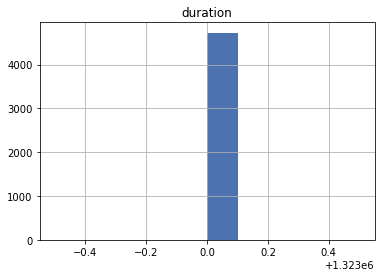

In [16]:
df_duraciones = pd.read_csv("duration.csv")
df_duraciones.hist()

In [122]:
def plot_example(df, recording_id):
    # Lectura y preparativos
    path = os.path.join(train_audios_dir, f"{recording_id}.flac")
    audio, sr = librosa.load(path)
    fig, ax = plt.subplots(nrows=2,figsize=(20,15), gridspec_kw={'height_ratios': [1, 3]})

    # Forma de onda
    librosa.display.waveplot(audio, sr, ax=ax[0])
    ax[0].set_title("Forma de onda")

    # Espectrograma
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    abs_stft = np.abs(stft)
    D = librosa.amplitude_to_db(abs_stft, ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',ax=ax[1])
    ax[1].set_title("Espectrograma")

    # Anotaciones
    df_recording_id = df.query("recording_id == @recording_id")
    for registro in df_recording_id.itertuples(index=False):
        t_min = registro.t_min
        t_max = registro.t_max
        f_min = registro.f_min
        f_max = registro.f_max

        ax[0].vlines(x=[t_min, t_max], ymin=audio.min(), ymax=audio.max(), color=np.random.random(size=3))
        ax[1].add_patch(Rectangle(xy=(t_min, f_min), width=t_max-t_min, height=f_max-f_min, ec='#00ff00', fill=False))
    
    # Detalles finales
    fig.colorbar(img, ax=ax[1])
    fig.suptitle(f"{recording_id}")
    fig.tight_layout(pad=2)


In [126]:
display(df.query("recording_id == '02b9a8ab9'"))

,recording_id,species_id,t_min,t_max,f_min,f_max,is_tp,duration,bandwidth
83,02b9a8ab9,0,35.3227,36.6133,5906.25,7500.00,False,1.2906,1593.75
84,02b9a8ab9,6,20.4053,22.4267,562.50,3187.50,False,2.0214,2625.00
85,02b9a8ab9,9,48.4267,51.2320,1125.00,5250.00,False,2.8053,4125.00
86,02b9a8ab9,12,33.9093,37.0453,562.50,3281.25,True,3.1360,2718.75


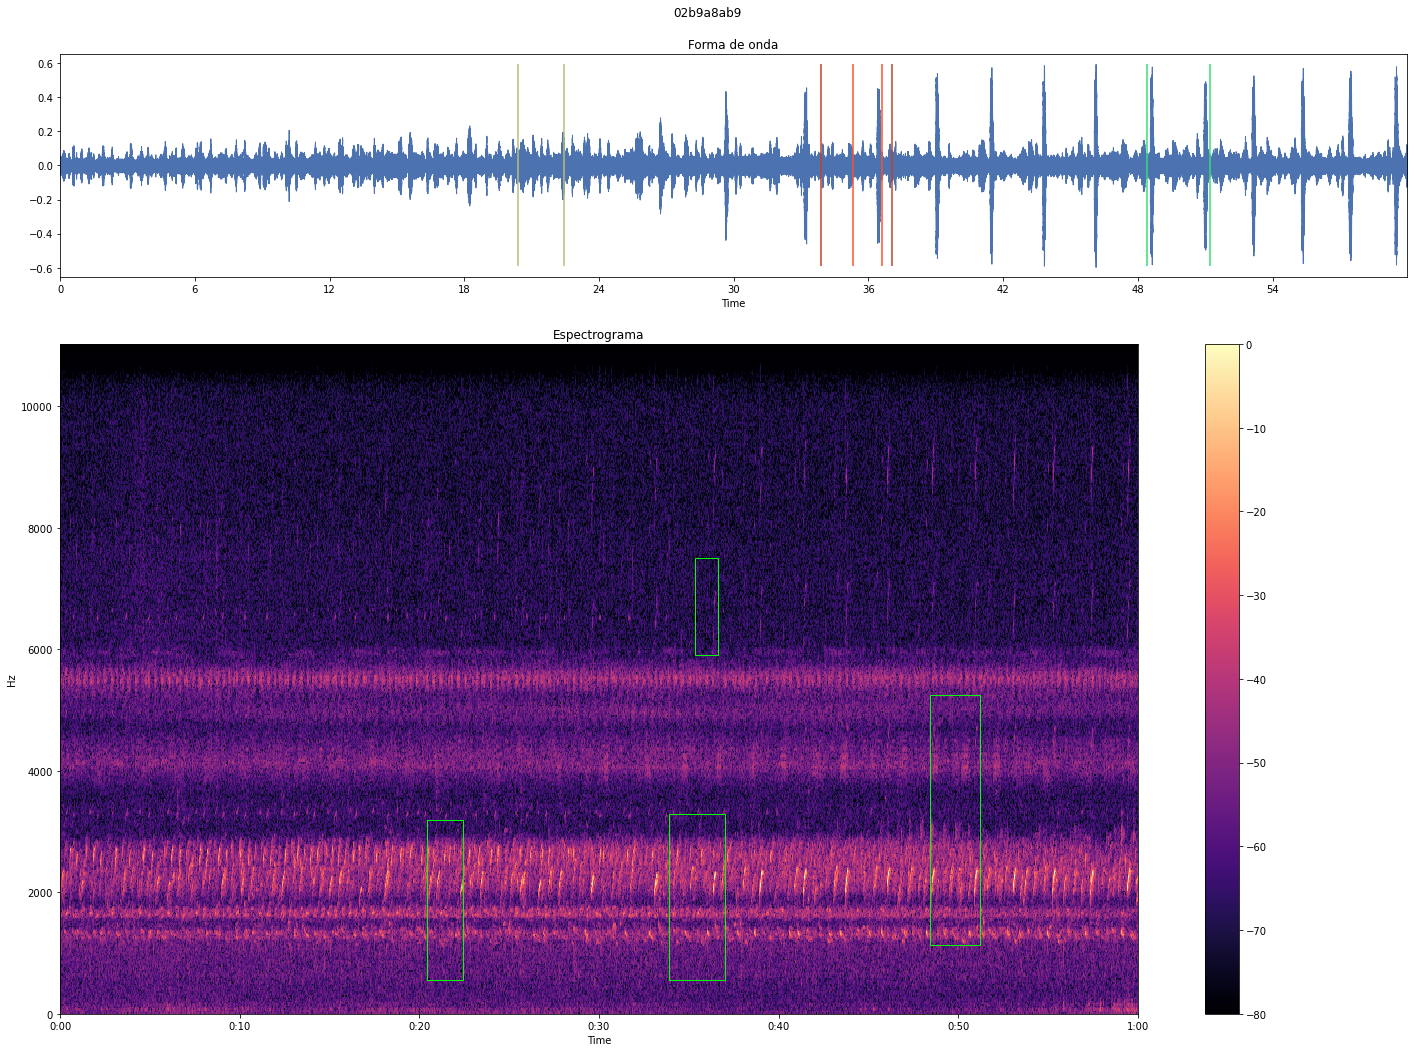

In [125]:
plot_example(df, "02b9a8ab9")